# 🔥 Gas Leakage — Multi-Class Classification

This notebook loads MQ-sensor readings from `gas_data.csv` (6,400 samples, 4 balanced classes: **NoGas**, **Perfume**, **Smoke**, **Mixture**), performs EDA, trains a **Random Forest Classifier**, evaluates it, and exports the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib, os, warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print('Libraries loaded ✅')

Libraries loaded ✅


## 1 — Load Data

In [2]:
df = pd.read_csv('../raw/gas_data.csv')
print(f'Total samples: {len(df)}')
print(f'Columns: {list(df.columns)}')
df.head()

Total samples: 6400
Columns: ['Serial Number', 'MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135', 'Gas', 'Corresponding Image Name']


,Serial Number,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas,Corresponding Image Name
0,0,555,515,377,338,666,451,416,NoGas,0_NoGas
1,1,555,516,377,339,666,451,416,NoGas,1_NoGas
2,2,556,517,376,337,666,451,416,NoGas,2_NoGas
3,3,556,516,376,336,665,451,416,NoGas,3_NoGas
4,4,556,516,376,337,665,451,416,NoGas,4_NoGas


In [3]:
# Define feature columns (7 MQ sensors) and target
sensor_cols = ['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']
target_col = 'Gas'

print('\nClass distribution:')
print(df[target_col].value_counts())
print(f'\nMissing values: {df[sensor_cols].isnull().sum().sum()}')
df[sensor_cols].describe()


Class distribution:
Gas
NoGas      1600
Perfume    1600
Smoke      1600
Mixture    1600
Name: count, dtype: int64

Missing values: 0


,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000
mean,677.593438,462.024688,404.579063,399.758750,565.952031,542.473750,416.727031
std,92.913955,70.284038,55.672249,45.091353,83.133693,151.020217,76.681407
min,502.000000,337.000000,291.000000,311.000000,361.000000,220.000000,275.000000
25%,591.000000,405.000000,366.000000,366.000000,524.000000,447.000000,354.000000
50%,701.000000,486.000000,400.000000,393.000000,576.000000,576.000000,437.000000
75%,756.000000,529.000000,443.000000,426.000000,629.000000,642.000000,473.000000
max,824.000000,543.000000,596.000000,524.000000,796.000000,794.000000,589.000000


## 2 — Exploratory Data Analysis

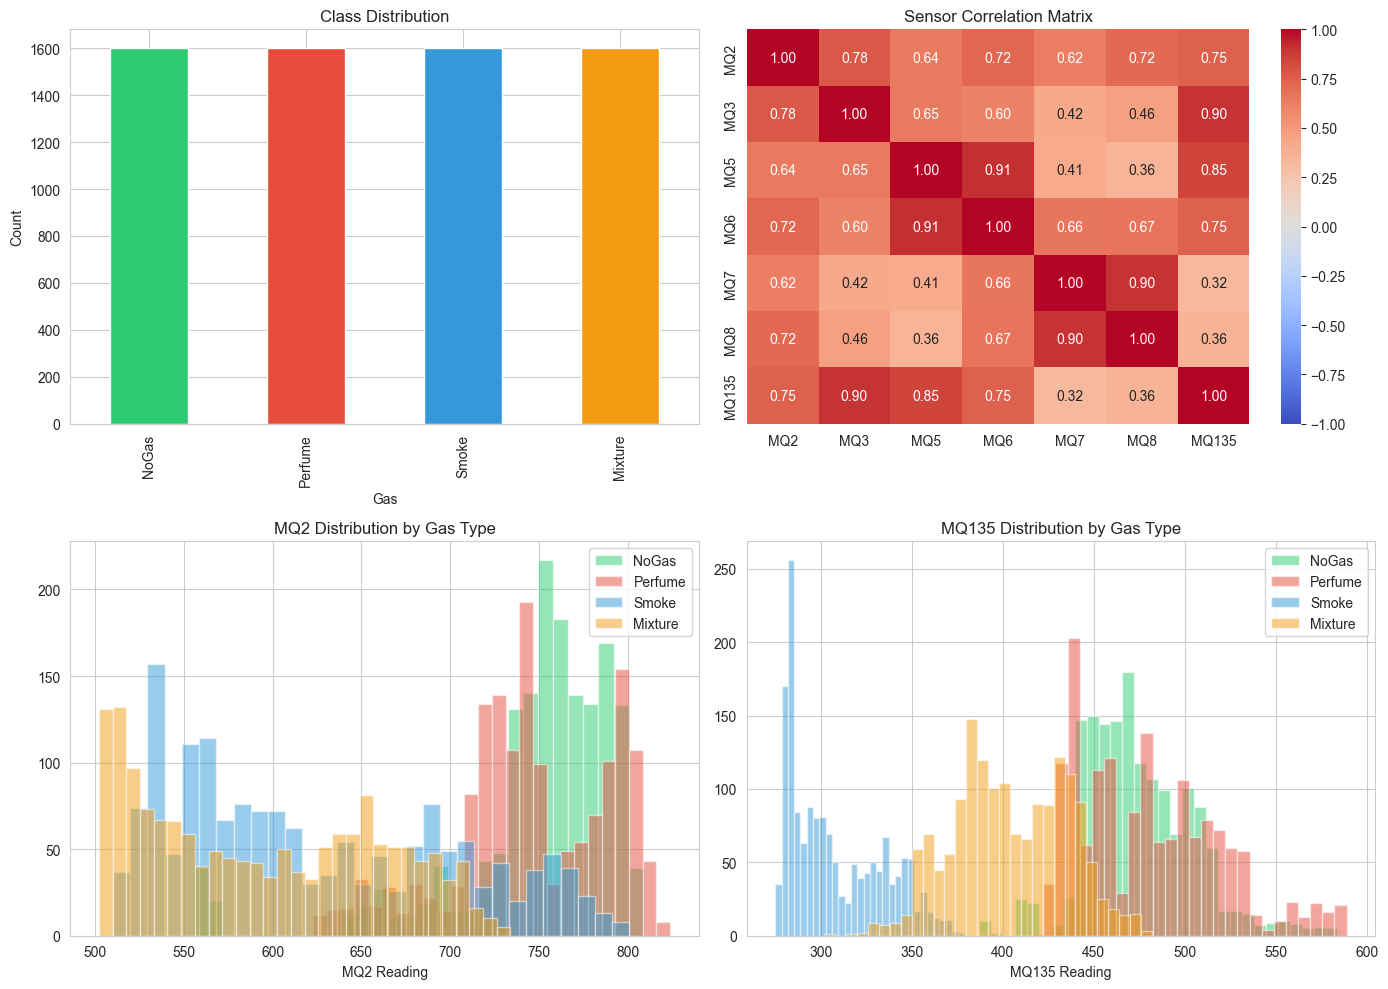

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Class distribution
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
df[target_col].value_counts().plot.bar(ax=axes[0, 0], color=colors, edgecolor='white')
axes[0, 0].set_title('Class Distribution')
axes[0, 0].set_ylabel('Count')

# Correlation heatmap
corr = df[sensor_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0, 1], vmin=-1, vmax=1)
axes[0, 1].set_title('Sensor Correlation Matrix')

# Sensor distributions by class (MQ2)
for gas_type, color in zip(df[target_col].unique(), colors):
    subset = df[df[target_col] == gas_type]
    axes[1, 0].hist(subset['MQ2'], bins=30, alpha=0.5, label=gas_type, color=color)
axes[1, 0].set_title('MQ2 Distribution by Gas Type')
axes[1, 0].set_xlabel('MQ2 Reading')
axes[1, 0].legend()

# MQ135 distribution by class
for gas_type, color in zip(df[target_col].unique(), colors):
    subset = df[df[target_col] == gas_type]
    axes[1, 1].hist(subset['MQ135'], bins=30, alpha=0.5, label=gas_type, color=color)
axes[1, 1].set_title('MQ135 Distribution by Gas Type')
axes[1, 1].set_xlabel('MQ135 Reading')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

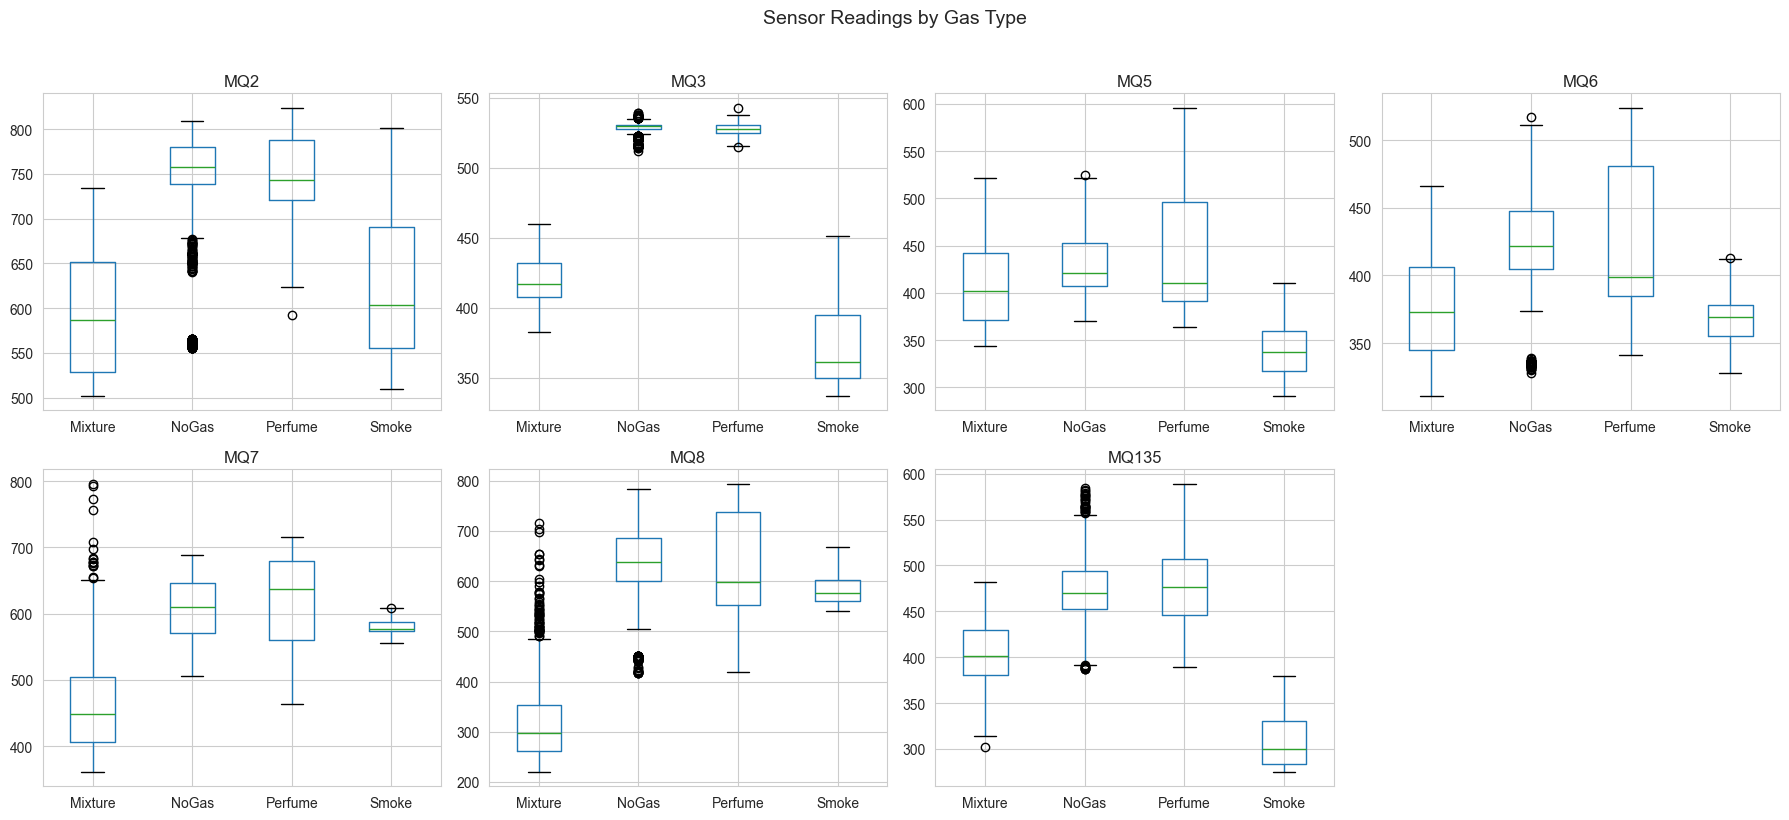

In [5]:
# Box plots per sensor grouped by gas type
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(sensor_cols):
    df.boxplot(column=col, by=target_col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')

axes[-1].axis('off')  # hide extra subplot
plt.suptitle('Sensor Readings by Gas Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3 — Train / Test Split

In [6]:
X = df[sensor_cols]
le = LabelEncoder()
y = le.fit_transform(df[target_col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'Train: {len(X_train)}, Test: {len(X_test)}')
print(f'Classes: {list(le.classes_)}')

Train: 5120, Test: 1280
Classes: ['Mixture', 'NoGas', 'Perfume', 'Smoke']


## 4 — Train Random Forest Classifier

In [7]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9766 (97.66%)

Classification Report:
              precision    recall  f1-score   support

     Mixture       1.00      1.00      1.00       320
       NoGas       0.95      0.96      0.95       320
     Perfume       0.96      0.95      0.95       320
       Smoke       1.00      1.00      1.00       320

    accuracy                           0.98      1280
   macro avg       0.98      0.98      0.98      1280
weighted avg       0.98      0.98      0.98      1280



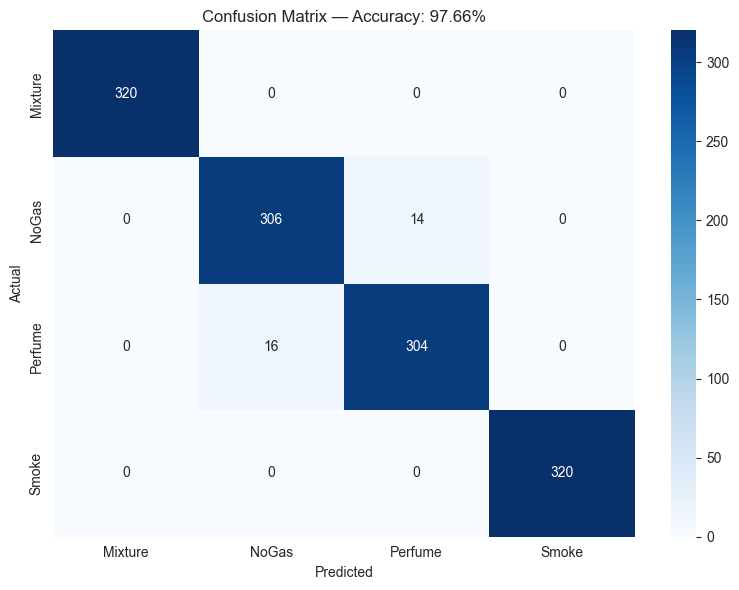

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix — Accuracy: {accuracy*100:.2f}%')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

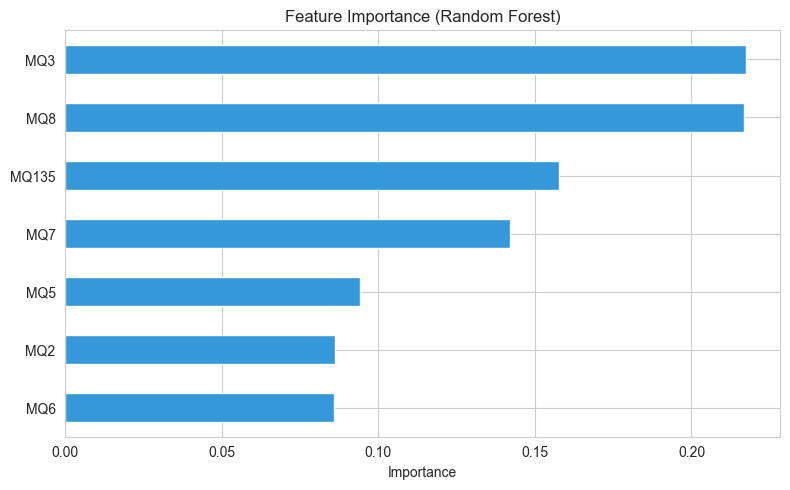

In [9]:
# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=sensor_cols).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
importances.plot.barh(color='#3498db', edgecolor='white')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 5 — Export Model

In [10]:
os.makedirs('../models', exist_ok=True)

joblib.dump({
    'random_forest': rf_model,
    'label_encoder': le,
    'features': sensor_cols,
    'classes': list(le.classes_),
    'accuracy': accuracy
}, '../models/gas_model.pkl')

print('✅ Model exported to models/gas_model.pkl')

✅ Model exported to models/gas_model.pkl
